In [1]:
import sys
import os

current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '..', 'src')
sys.path.append(src_dir)

import pandas as pd
from dqc.dqc import DataQualityPipeline
from etl.etl import ETL, RelationsTransform
from etl.kaggle_data_loader import download_data

In [2]:
download_data()

data_paths = {}

for dirname, _, filenames in os.walk(f'{src_dir}/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        data_paths[filename] = f"{dirname}/{filename}"

relations = {}

for file, path in data_paths.items():
    relations[file.split('.')[0]] = pd.read_csv(path)

/home/sandra/Projects/ds_practice/notebooks/../src/data/sales_train.csv
/home/sandra/Projects/ds_practice/notebooks/../src/data/item_categories.csv
/home/sandra/Projects/ds_practice/notebooks/../src/data/sample_submission.csv
/home/sandra/Projects/ds_practice/notebooks/../src/data/items.csv
/home/sandra/Projects/ds_practice/notebooks/../src/data/test.csv
/home/sandra/Projects/ds_practice/notebooks/../src/data/shops.csv


In [3]:
report = DataQualityPipeline()(relations)

In [4]:
filter_pipes = {
        "sales_train": [lambda df: df[(-10 < df["item_price"]) & (df["item_price"]  <= 60000)],
                        lambda df: df[(0 <= df["item_cnt_day"]) & (df["item_cnt_day"] <= 4.0)],
                        lambda df: df[~df.duplicated(keep="first")],
                        ],
    }

transform = RelationsTransform(filter_pipes)

etl = ETL(transform)
full_relations = etl.load()

# Exploratory Data Analysis:
1. Calculate descriptive statistics
2. Visualize the data using graphs, charts, and histograms
3. Identify patterns and trends in the data
4. Test hypotheses and make predictions based on the data

In [5]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

* City name extraction and cleaning 

In [6]:
city_names = full_relations['shop_name'].str.split(" ").str[0]

not_cities = ["Выездная", "Жуковский", "Интернетмагазин", "Интернет-магазин", "СПб", "Сергиев", "Цифровой"]
cities = [city if not city in not_cities else "None" for city in city_names]
city_names = pd.Series(cities).replace("!Якутск","Якутск")

* General item category extraction 

In [7]:
item_cats = full_relations['item_category_name'].str.split("-").str[0]

In [8]:
full_relations["date"] = pd.to_datetime(full_relations["date"], format="%d.%m.%Y")
full_relations["year"] = full_relations["date"].dt.year
full_relations["month"] = full_relations["date"].dt.month
full_relations["day_of_month"] = full_relations["date"].dt.day
full_relations["week_of_year"] = full_relations["date"].dt.isocalendar().week

full_relations["day_revenue"] = full_relations["item_price"]*full_relations["item_cnt_day"]
full_relations["shop_city"] = city_names
full_relations["gen_item_category"] = item_cats
full_relations.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day_of_month,week_of_year,day_revenue,shop_city,gen_item_category
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",2013,1,2,1,999.00,Ярославль,Кино
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013,1,3,1,899.00,Москва,Музыка
2,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013,1,6,1,1709.05,Москва,Музыка


## Year dynamics

In [9]:
week_revenue_sum_1 = pd.DataFrame(full_relations.groupby(["year", "week_of_year"])["day_revenue"].sum())
week_revenue_mean = pd.DataFrame(full_relations.groupby(["year", "week_of_year"])["day_revenue"].mean())
week_item_cnt_sum_2 = pd.DataFrame(full_relations.groupby(["year", "week_of_year"])["item_cnt_day"].sum())
week_stats = {"sum_1": week_revenue_sum_1,
              "mean": week_revenue_mean,
              "sum_2": week_item_cnt_sum_2
              }

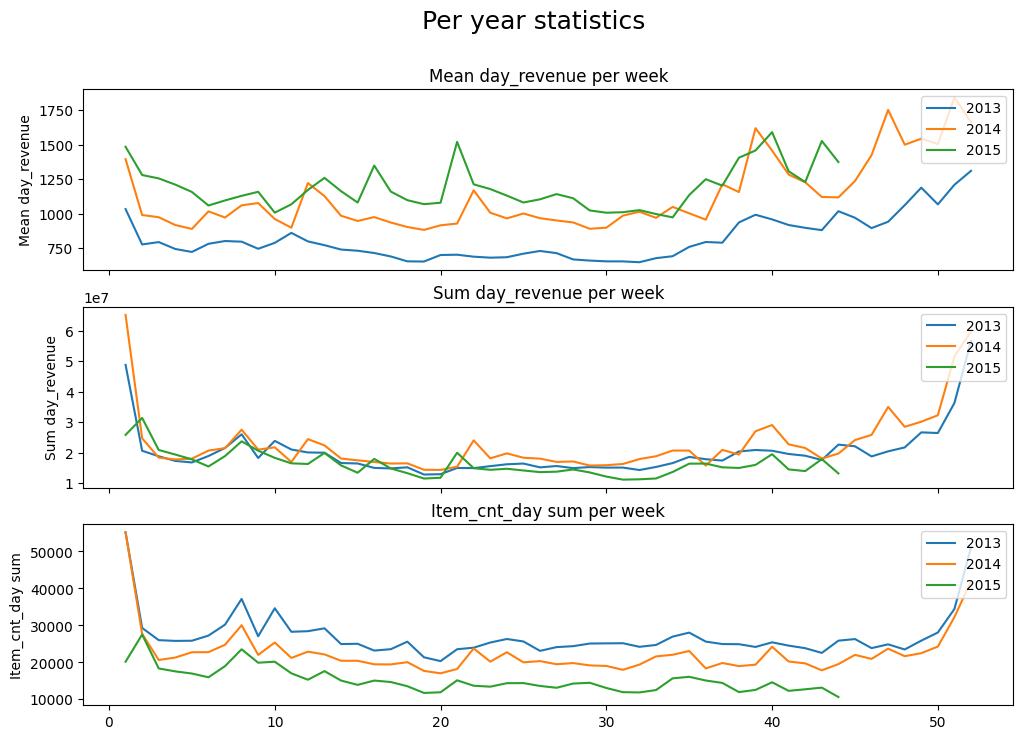

In [10]:
years = [2013, 2014, 2015]
keys = sorted(week_stats.keys())
labels = ["Mean day_revenue", "Sum day_revenue", "Item_cnt_day sum"]

fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle("Per year statistics", size=18)
for j in range(len(keys)):
    for i in range(len(years)):
        table = week_stats[keys[j]].loc[years[i]]
        
        axs[j].plot(table, label=str(years[i]))
        axs[j].legend(loc='upper right')
    axs[j].set(ylabel=labels[j])
    axs[j].set_title(f'{labels[j]} per week')

In [11]:
# Last week for 2015
max(pd.DataFrame(full_relations.groupby(["year", "week_of_year"])["item_id"].sum()).loc[2015].index)

44

* Incoplete 2015 from week 44
* Item sales are going up at the end of years 2013-2014

## Per month dynamics

In [12]:
month_item_cnt_day = full_relations.groupby(['year', 'month', 'day_of_month'], as_index=False).item_cnt_day.sum()

In [13]:
months = {1: 'January',
          2: 'February',
          3: 'March',
          4: 'April',
          5: 'May',
          6: 'June',
          7: 'July',
          8: 'August',
          9: 'September',
          10: 'October',
          11: 'November',
          12: 'December'}

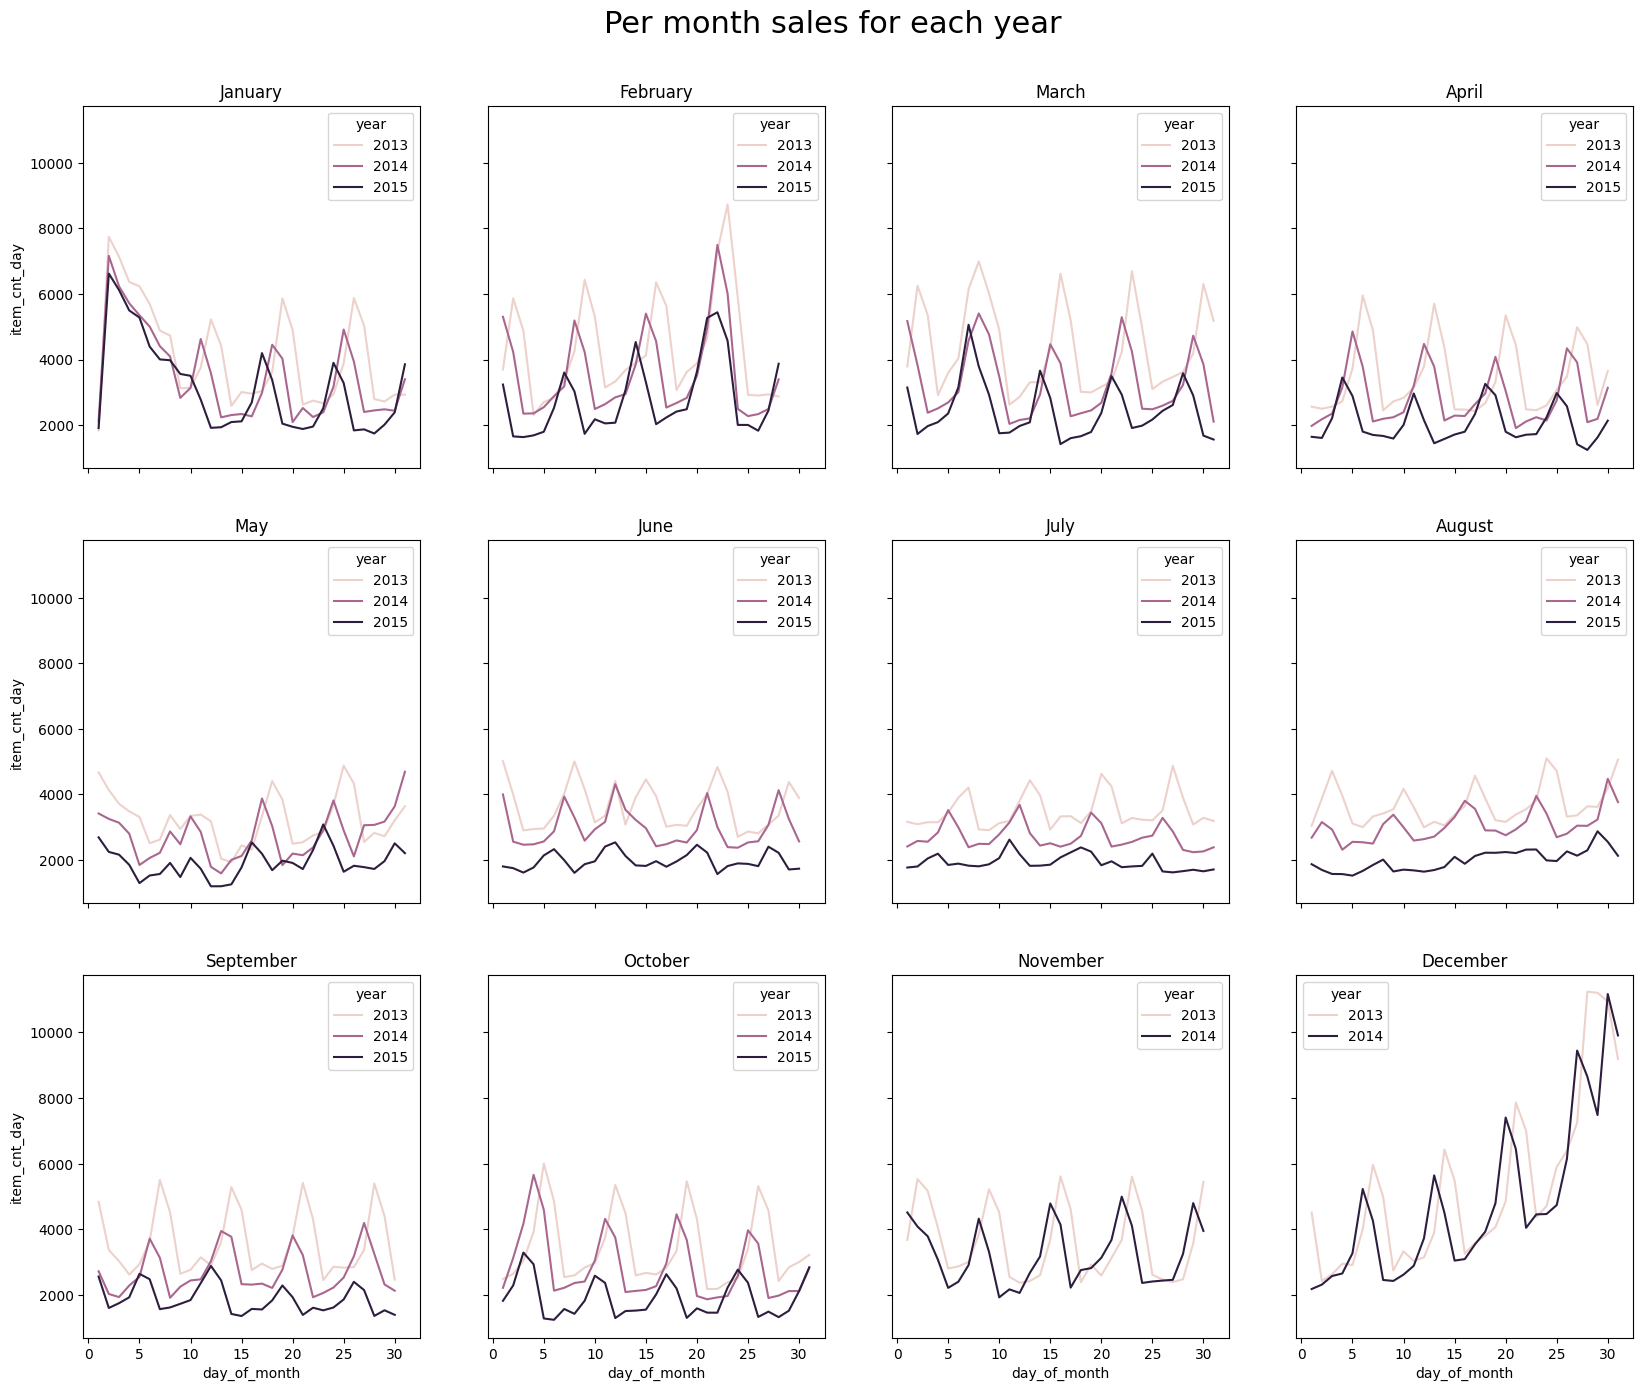

In [14]:
fig, axes = plt.subplots(3, 4, figsize=(20,16), sharex=True, sharey=True)
fig.suptitle('Per month sales for each year', y=0.94, size=22)
for i in range(1,4):
    for j in range(1,5):
        sns.lineplot(ax=axes[i-1, j-1], 
                     data = month_item_cnt_day.loc[month_item_cnt_day.month==(i-1)*4+j], 
                     x = 'day_of_month', 
                     y='item_cnt_day', 
                     hue='year'
                    ).set_title(months[(i-1)*4+j])
plt.show()

* We can see some year and month patterns
* Incomplete last two months
* Sales grow closer to the holidays

## Shops total revenue

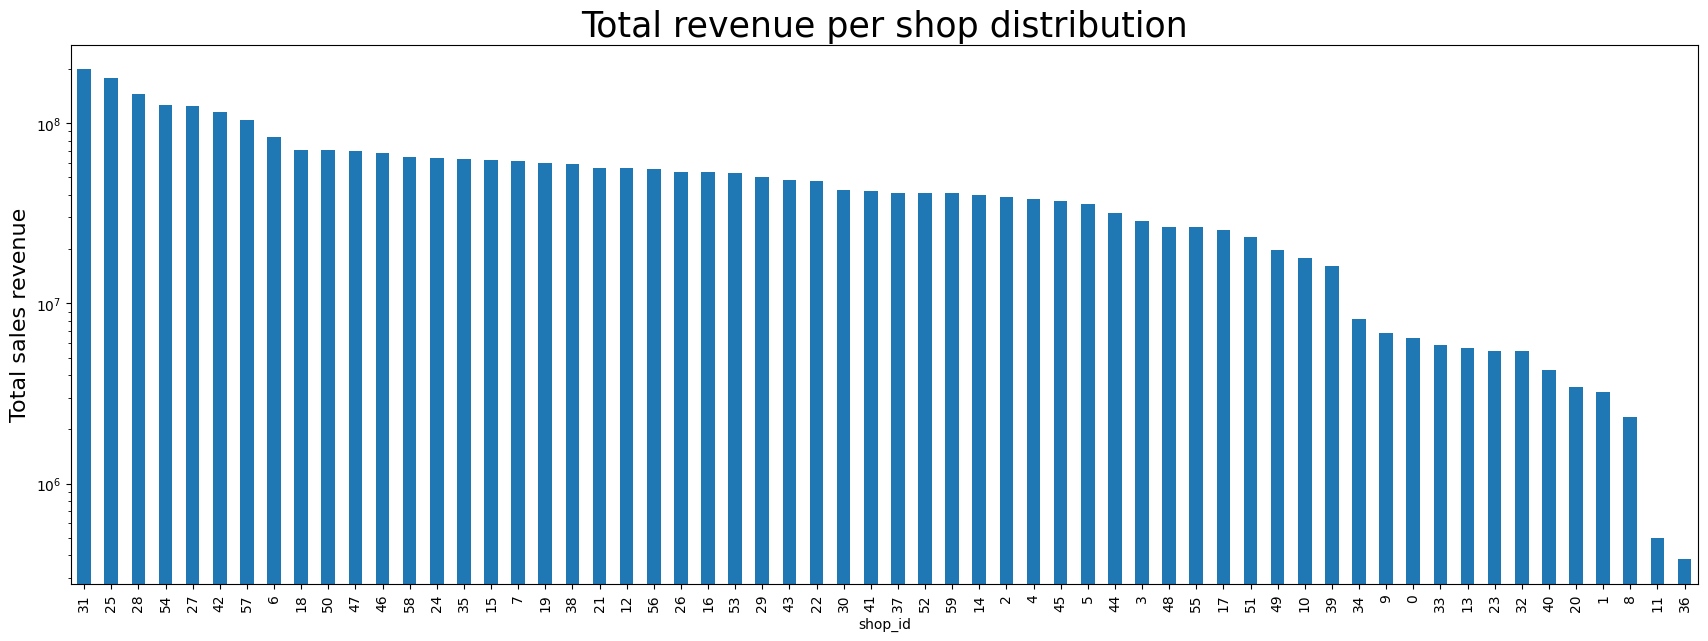

In [15]:
shops_revenue = full_relations[["shop_id", "day_revenue"]].groupby("shop_id").sum()["day_revenue"]
plt.title("Total revenue per shop distribution", size=25)
plt.ylabel("Total sales revenue", size=16)
shops_revenue.sort_values(ascending=False).plot.bar(figsize=(21, 7), logy=True)
plt.show()

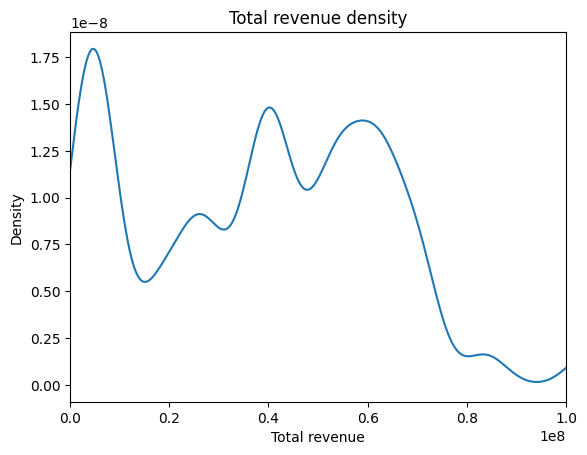

In [16]:
plt.xlabel("Total revenue")
plt.xlim([0, 10**8])
plt.title("Total revenue density")
shops_revenue.plot.kde(bw_method=0.1);
plt.show()

* Most frequent revenue values are 0.05 * 10^8, 0.4 * 10^8 and 0.6 * 10^8 among all shops

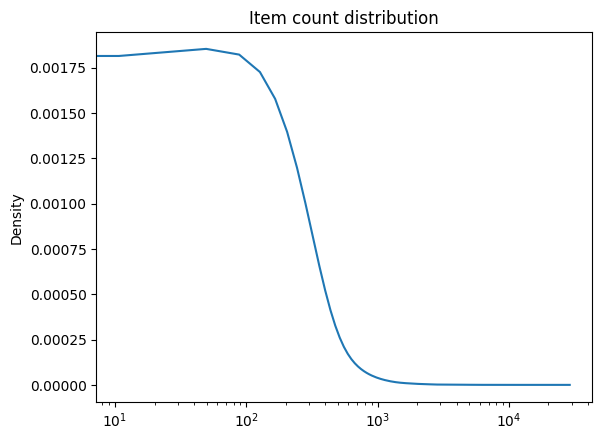

In [17]:
item_count = full_relations.groupby(["item_id"])["item_id"].count()
plt.title("Item count distribution")

item_count.plot.kde(bw_method=0.5, logx=True);

* From 1 to 10^3 the most frequent item_ids

## Revenue per shop dynamics

In [18]:
df = full_relations.groupby(['date_block_num','shop_id'], as_index=False).sum(numeric_only=True)
# df = df.loc[df.shop_id.isin(np.arange(20,30))]
fig = px.bar(df, x='date_block_num', y = 'day_revenue', color='shop_id', title="Shops' total revenue per month [color - shop_id]")
fig.show()

In [19]:
gp_month_mean = full_relations.groupby(['month'], as_index=False)['day_revenue'].mean()
gp_month_sum = full_relations.groupby(['month'], as_index=False)['day_revenue'].sum()
gp_category_mean = full_relations.groupby(['item_category_id'], as_index=False)['day_revenue'].mean()
gp_category_sum = full_relations.groupby(['item_category_id'], as_index=False)['day_revenue'].sum()
gp_shop_mean = full_relations.groupby(['shop_id'], as_index=False)['day_revenue'].mean()
gp_shop_sum = full_relations.groupby(['shop_id'], as_index=False)['day_revenue'].sum()

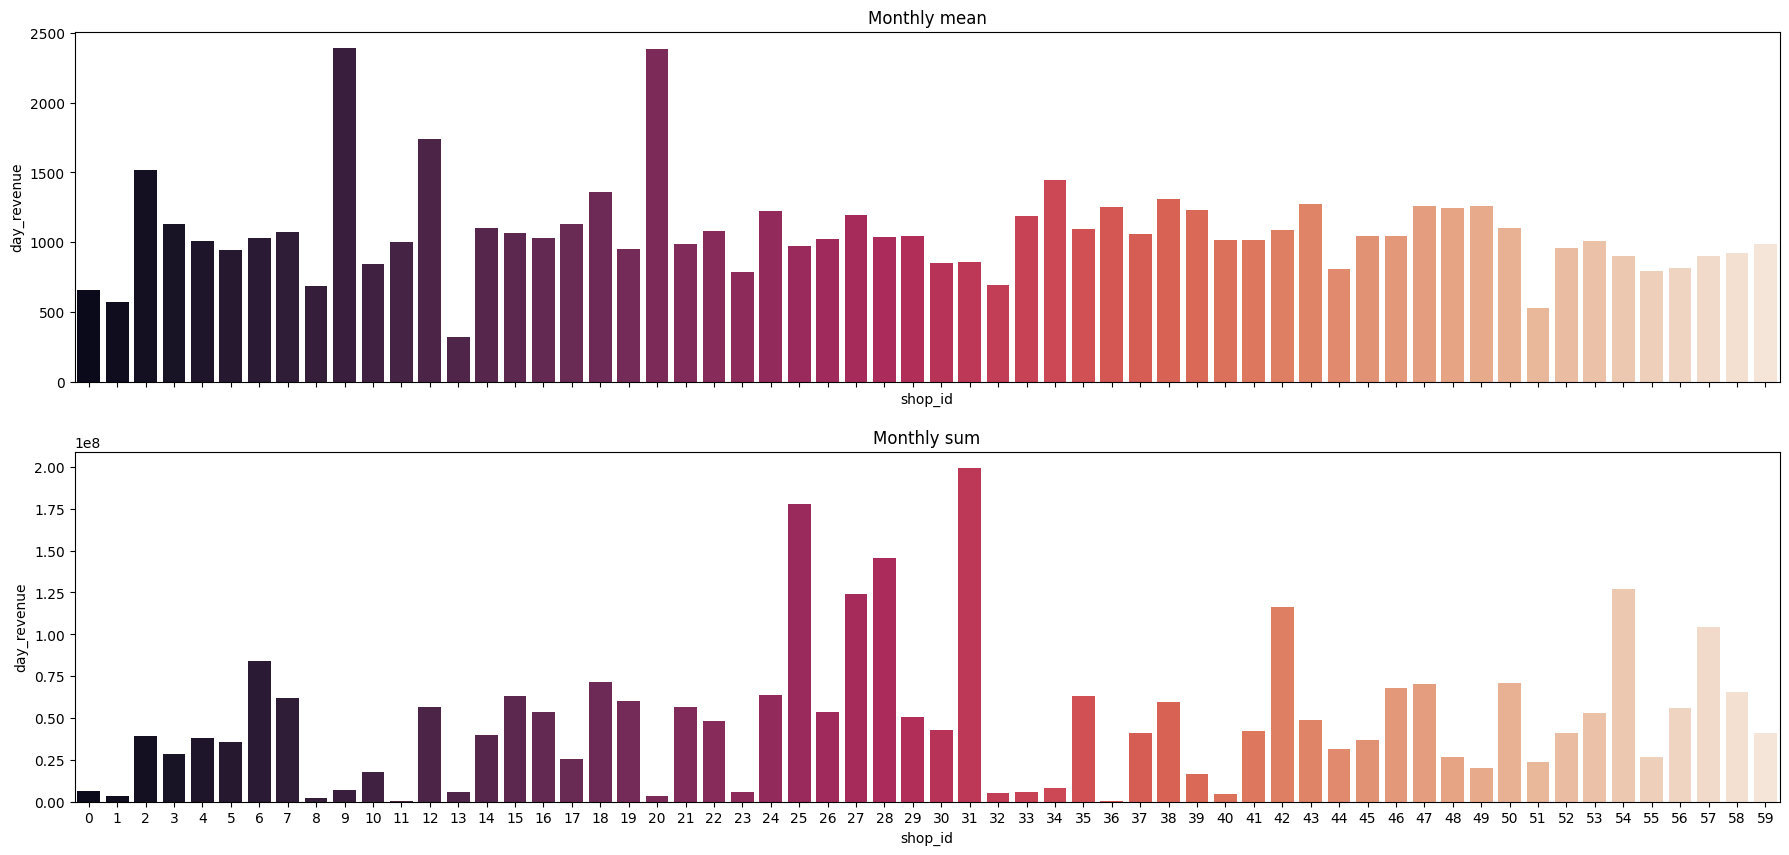

In [20]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="day_revenue", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="day_revenue", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

## Sales per city

In [21]:
df = full_relations.groupby(['date_block_num','shop_city'], as_index=False).sum(numeric_only=True)
fig = px.bar(df, x='date_block_num', y = 'item_cnt_day', 
             color='shop_city', title="Sum of items sold per month [labels - city]")
fig.show()

* The highest sales rate is in Moscow among other cities

## Item categories

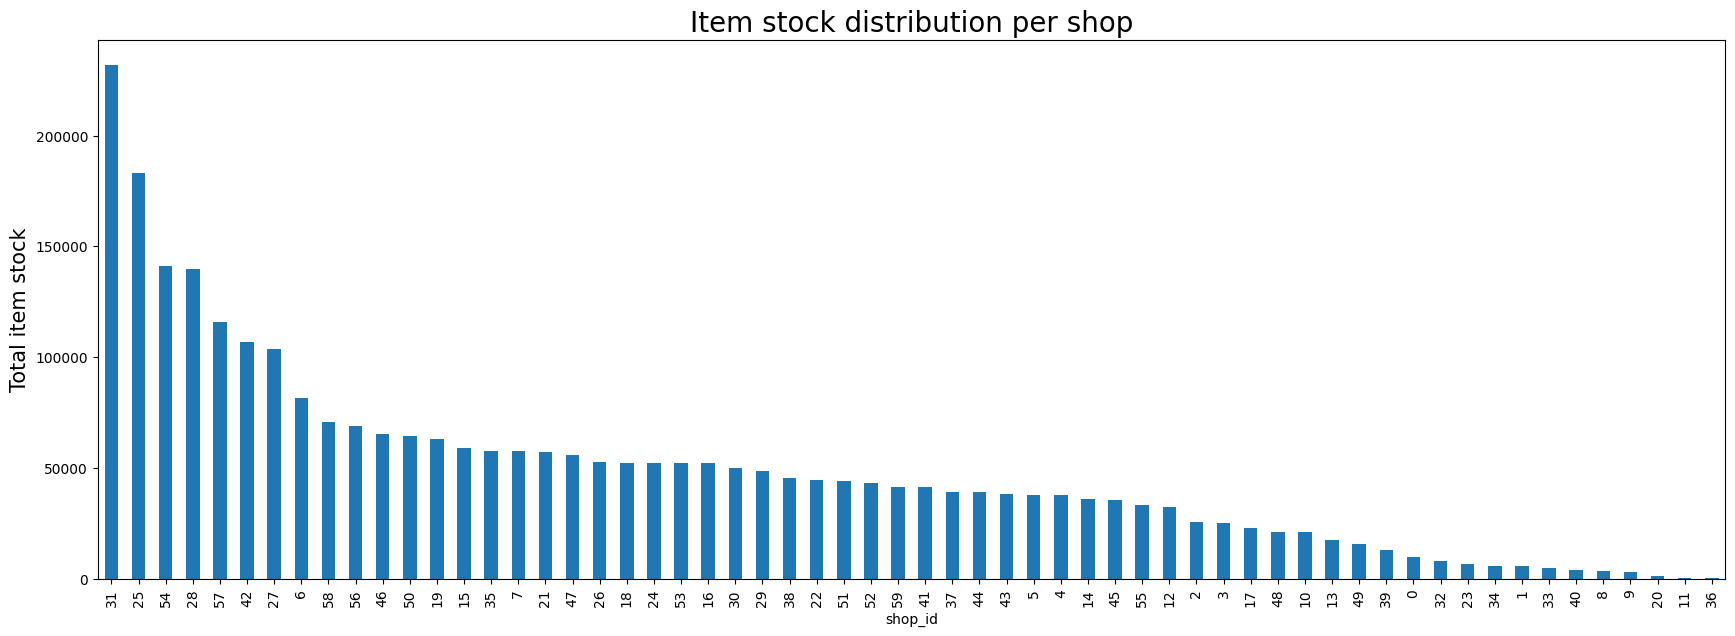

In [22]:
shops_items = full_relations.groupby("shop_id")["item_id"].count()
shops_items.sort_values(ascending=False).plot.bar(figsize=(21, 7))
plt.title("Item stock distribution per shop", size=20)
plt.ylabel("Total item stock", size=15)
plt.show();

In [23]:
item_cats = full_relations.groupby(['date_block_num','item_category_name'], as_index=False).sum(numeric_only=True)
fig = px.bar(item_cats, x='date_block_num', y = 'item_cnt_day', color='item_category_name', \
             title="Items sold per date_block_num [color - item_category_name]")
fig.show()

In [24]:
gen_item_cats = full_relations.groupby(['date_block_num','gen_item_category'], as_index=False).sum(numeric_only=True)
fig = px.bar(gen_item_cats, x='date_block_num', y = 'item_cnt_day', color='gen_item_category', \
             title="Items sold per date_block_num [color - gen_item_category]")
fig.show()

* Games, games PC, films, music and gifts are the most frequent categories

## Item price dynamics

In [25]:
mean_item_price = full_relations.groupby(["item_id"])["item_price"].mean()
std_item_price = full_relations.groupby(["item_id"])["item_price"].std(ddof=0)

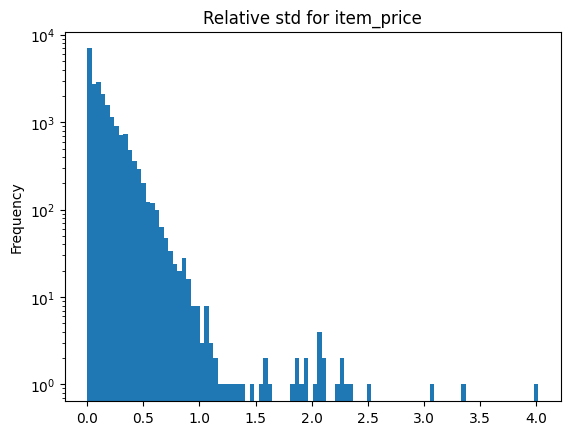

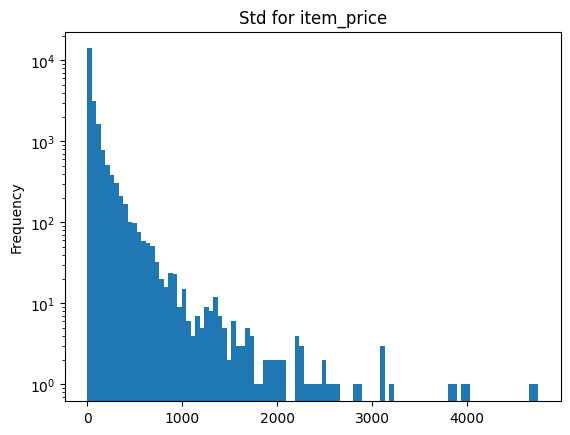

In [26]:
(std_item_price/mean_item_price).plot.hist(bins=100, logy=True)
plt.title("Relative std for item_price")
plt.figure()
std_item_price.plot.hist(bins=100, logy=True)
plt.title("Std for item_price");

* it's shown in the first plot that some items have std(price)/mean(price) >= 1.0
over the entire period of sales, which means that the price fluctuates a lot
* the second plot shows absolute std over item_price
* to see specific item_ids we can just search trough table as below 

In [27]:
mean_item_price[std_item_price/mean_item_price>=3.5]
# full_relations[full_relations['item_id'] == 11860]

item_id
11860    16.049351
Name: item_price, dtype: float64

In [28]:
mean_item_city = full_relations.groupby(["shop_city"]).mean(numeric_only=True)

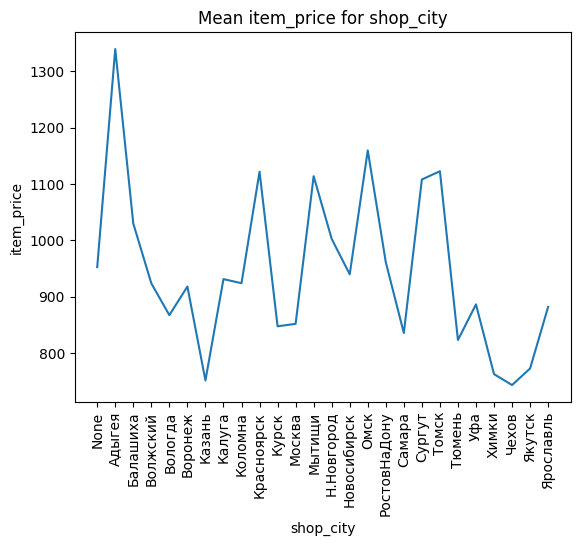

In [29]:
sns.lineplot(data=mean_item_city,
             x="shop_city",
             y='item_price')
plt.title("Mean item_price for shop_city")
plt.xticks(rotation=90);

* As was mentioned above, Moscow has the highest sales rate and also the biggest amount of shops (shown below), but still the mean item_price is low -> maybe they sell low cost goods or they may have the lowest prices, maybe both -> it explains the high sales rate

In [30]:
shops_per_city = full_relations.groupby(["shop_city", "shop_id"]).mean(numeric_only=True)
shops_per_city

date_block_num       item_id   item_price  item_cnt_day  \
shop_city    shop_id                                                            
None         9             18.993743  13739.058047  1335.760781      1.854362   
             10            14.176327   9259.632139   766.726302      1.084703   
             11            25.000000   9678.993927   961.635364      1.068826   
             12            17.446705   9935.488063  1436.251300      1.181871   
             42            16.106433  10484.957762   920.792608      1.123161   
             43            11.743451   9584.385331  1077.166022      1.132301   
             46            14.379104   9852.753705   918.532878      1.108342   
             55            20.536216   6845.456628   590.740548      1.251849   
Адыгея       2             16.671300   8554.207608  1339.586737      1.113343   
Балашиха     3             15.907533   9000.516222  1029.853177      1.077629   
Волжский     4             14.492828   9164.391738   923.615835      1.093389   
Вологда      5             16.506376  10100.975894   867.202368      1.082086   
Воронеж      6             14.069454   9918.482676   896.467528      1.112874   
             7             14.845862   9668.635249   964.255055      1.095019   
             8              0.863650  10041.758155   652.654042      1.053482   
Казань       13             8.453592  12400.579790   298.491569      1.078268   
             14            14.687821   9075.717784   973.184381      1.118442   
Калуга       15            14.259194   9586.128154   931.197889      1.119444   
Коломна      16            13.563726   9868.142665   923.926636      1.100732   
Красноярск   17            14.222990   9902.762443  1019.121108      1.086872   
             18            13.464812   8995.074614  1166.485583      1.124141   
Курск        19            14.489033   9908.116676   847.432163      1.102064   
Москва       20            26.834254  17096.774171  1402.332914      1.770028   
             21            16.144394  10774.139216   883.385532      1.091950   
             22            14.648139   9651.612937   922.474971      1.145762   
             23             1.453270   9487.209491   721.510616      1.082031   
             24            14.683081   9146.498119  1060.423570      1.125026   
             25            15.050117  10822.047911   828.628114      1.136840   
             26            14.193455   9994.214691   892.449189      1.109986   
             27            14.494895   9793.765816  1000.286034      1.152694   
             28            14.817330  10522.026251   880.300774      1.154074   
             29            12.083148  10076.559468   915.605787      1.116506   
             30            11.048656  10405.122619   766.321509      1.097431   
             31            14.937513  11073.233978   721.188528      1.148254   
             32             2.485769   9858.933418   638.271806      1.068742   
Мытищи       33            22.948805  10436.586428  1113.921785      1.075286   
Н.Новгород   34            25.986121   9625.680253  1332.348947      1.085910   
             35            15.247430   9612.264020   969.976821      1.100841   
Новосибирск  36            33.000000  11215.528053  1171.854785      1.099010   
             37            13.820865   9582.618669   937.936581      1.097182   
Омск         38            15.889128   8997.203433  1159.576967      1.105992   
РостовНаДону 39            23.519362  10370.402126  1121.642683      1.106150   
             40            19.660952  13290.266905   967.065000      1.105952   
             41            13.467114   9738.230732   909.489162      1.090521   
Самара       44            13.834396  10888.044997   742.019089      1.090609   
             45            13.835802   9820.434572   938.504469      1.093566   
Сургут       47            16.568581   9287.791491  1108.004010      1.106804   
Томск        48            23.850713   9738.932936  1

## Correlation

In [31]:
from statsmodels.graphics.tsaplots import plot_acf

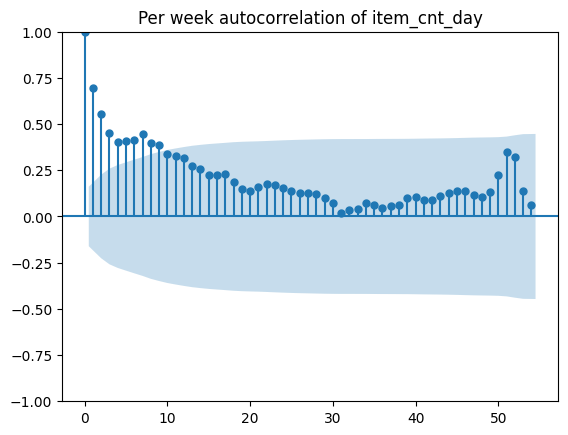

In [45]:
batch = []
for year in [2013, 2014, 2015]:
    batch.append(full_relations.loc[full_relations.year==year].groupby(['week_of_year']).sum(numeric_only=True).item_cnt_day) 
plot_acf(pd.concat(batch, ignore_index=True), title='Per week autocorrelation of item_cnt_day', lags=54)
plt.show()

In [44]:
full_relations.loc[full_relations.year==2013,['item_price', 'item_cnt_day','date']]\
           .groupby('date', as_index=False)\
           .sum()\
           .corr(numeric_only=False)

,date,item_price,item_cnt_day
date,1.000000,0.227762,0.026271
item_price,0.227762,1.000000,0.927750
item_cnt_day,0.026271,0.927750,1.000000


* We can see there is a correlation between item_cnt_day and item_price -> the bigger sum of sales the bigger amount of item sold